# Persiapan Awal: Mount Drive dan Instalasi

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!pip install split-folders tensorflow

Mounted at /content/drive


# Pemisahan Data: Split Folders

Karena pada dataset data train dan test sudah terpisah, akan tetapi belum ada data untuk validasi yang diperlukan untuk memonitor overfitting selama pelatihan maka yang dilakukan adalah membagi folder train yang ada menjadi dua bagian baru yaitu:


*   train_new (sekitar 80-90% dari data train lama)
*   val (sekitar 10-20% dari data train lama)



In [ ]:
import splitfolders
import os
import shutil

#pendefinisian lokasi data
#path folder train yang sudah ada
INPUT_TRAIN_FOLDER = "/content/drive/MyDrive/Data Science/Computer Vision/01 - CNN Deteksi Jenis Hama dan Serangga/pests_serangga_dataset/train"
#folder sementara buat tampung hasil pemisahan train -> train new & val
TEMP_SPLIT_OUTPUT = "/content/drive/MyDrive/Data Science/Computer Vision/01 - CNN Deteksi Jenis Hama dan Serangga/pests_serangga_dataset/temp_split_output"

#hapus folder output sementara sebelumnya jika ada
if os.path.exists(TEMP_SPLIT_OUTPUT):
  print(f"Menghapus folder lama: {TEMP_SPLIT_OUTPUT}")
  shutil.rmtree(TEMP_SPLIT_OUTPUT)

print(f"Memulai pemisaan data training menjadi train baru dan valdation....")

#split folder train baru (90%) dan validasi (10%)
#set rasio test dikasih 0.0 karena tidak memerlukannya
splitfolders.ratio(
    INPUT_TRAIN_FOLDER,
    output=TEMP_SPLIT_OUTPUT,
    seed=42,
    ratio=(0.9, 0.1, 0.0),
    group_prefix=None,
)

print(f"\nPemisahan selesai. Output sementara di: {TEMP_SPLIT_OUTPUT}")

Menghapus folder lama: /content/drive/MyDrive/Data Science/Computer Vision/01 - CNN Deteksi Jenis Hama dan Serangga/pests_serangga_dataset/temp_split_output
Memulai pemisaan data training menjadi train baru dan valdation....


Copying files: 2232 files [00:45, 49.59 files/s]


Pemisahan selesai. Output sementara di: /content/drive/MyDrive/Data Science/Computer Vision/01 - CNN Deteksi Jenis Hama dan Serangga/pests_serangga_dataset/temp_split_output


# Implementasi CNN: Loading Data dan Model Building

In [ ]:
#Data loading dan data processing

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#penyesuaian path
TRAIN_VAL_DIR = "/content/drive/MyDrive/Data Science/Computer Vision/01 - CNN Deteksi Jenis Hama dan Serangga/pests_serangga_dataset/temp_split_output"
#lokasi data test sejak awal
TEST_DIR = "/content/drive/MyDrive/Data Science/Computer Vision/01 - CNN Deteksi Jenis Hama dan Serangga/pests_serangga_dataset/test"

#pendefinisen hyperparameter
IMAGE_SIZE = (150, 150)
BATCH_SIZE = 32

#generator untuk data traiin (dengan augmentasi)
train_datagen = ImageDataGenerator(
    rescale=1./255, #normalisasi pixel
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

#generator untuk validasi dan uji (hanya normaliasi)
val_test_datagen = ImageDataGenerator(rescale=1./255)

#1. memuat data latih dari folder train dalam temp_split_output
train_generator = train_datagen.flow_from_directory(
    os.path.join(TRAIN_VAL_DIR, 'train'),
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

#2. memuat data validasi dari volder val di dalam temp_split_output
validation_generator = val_test_datagen.flow_from_directory(
    os.path.join(TRAIN_VAL_DIR, 'val'),
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

#3. memuat data uji dari folder asli
test_generator = val_test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

NUM_CLASSES = train_generator.num_classes
print(f"Jumlah kelas hama dan serangga yang ditemukan: {NUM_CLASSES}")

class_names = list(train_generator.class_indices.keys())
print(f"\nNama-Nama Kelas: {class_names}")

Found 2004 images belonging to 9 classes.
Found 220 images belonging to 9 classes.
Found 384 images belonging to 9 classes.
Jumlah kelas hama dan serangga yang ditemukan: 9

Nama-Nama Kelas: ['aphids', 'armyworm', 'beetle', 'bollworm', 'grasshopper', 'mites', 'mosquito', 'sawfly', 'stem_borer']


In [ ]:
#pendefinisian dan melatih model cnn

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

#pendefinisian model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dropout(0.5),
    Dense(512, activation='relu'),

    #lapisan output: jumlah neuron harus sama dengan jumlah kelas
    Dense(NUM_CLASSES, activation='softmax')
])

#kompilasi model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

#pelatohan model
EPOCHS = 50

print("\nMemulai pelatihan model...")
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE
)

print("Pelatihan selesai")

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 9)              │         4,617 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,038,281 (72.63 MB)

 Trainable params: 19,038,281 (72.63 MB)

 Non-trainable params: 0 (0.00 B)


Memulai pelatihan model...
Epoch 1/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 131s 2s/step - accuracy: 0.1429 - loss: 2.5504 - val_accuracy: 0.2656 - val_loss: 1.9813
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.2188 - loss: 1.9944 - val_accuracy: 0.2812 - val_loss: 1.9500
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 127s 2s/step - accuracy: 0.2683 - loss: 1.9779 - val_accuracy: 0.3385 - val_loss: 1.6864
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - accuracy: 0.3750 - loss: 1.7770 - val_accuracy: 0.3177 - val_loss: 1.7040
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.3416 - loss: 1.8057 - val_accuracy: 0.5104 - val_loss: 1.5164
Epoch 6/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - accuracy: 0.3750 - loss: 1.6504 - val_accuracy: 0.5260 - val_loss: 1.4851
Epoch 7/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 130s 2s/step - accuracy: 0.3817 - loss: 1.7007 - val_accuracy: 0.5156 - val_loss: 1.3969
Epoch 8/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.5938 - loss: 1.347

In [ ]:
#simpan hasil pemodelan

# Tentukan path penyimpanan model di Google Drive
MODEL_SAVE_PATH = os.path.join("/content/drive/MyDrive/Data Science/Computer Vision/01 - CNN Deteksi Jenis Hama dan Serangga/pests_serangga_dataset/models", 'serangga_cnn_model_v1.h5')

# Pastikan folder 'models' ada di Drive
os.makedirs(os.path.dirname(MODEL_SAVE_PATH), exist_ok=True)

# Simpan Model
model.save(MODEL_SAVE_PATH)
print(f"\nModel berhasil disimpan ke Google Drive di: {MODEL_SAVE_PATH}")


Model berhasil disimpan ke Google Drive di: /content/drive/MyDrive/Data Science/Computer Vision/01 - CNN Deteksi Jenis Hama dan Serangga/pests_serangga_dataset/models/serangga_cnn_model_v1.h5


# Evaluasi Hasil Pemodelan Dengan Data Uji (Test)

In [ ]:
#evaluasi dengan data uji

import tensorflow as tf
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- PATH YANG PERLU DISESUAIKAN (Gunakan path yang sama dengan sebelumnya) ---
# Lokasi data test yang sudah ada sejak awal
TEST_DIR = "/content/drive/MyDrive/Data Science/Computer Vision/01 - CNN Deteksi Jenis Hama dan Serangga/pests_serangga_dataset/test"
# Lokasi model yang sudah disimpan (hasil epoch 50)
MODEL_SAVE_PATH = os.path.join("/content/drive/MyDrive/Data Science/Computer Vision/01 - CNN Deteksi Jenis Hama dan Serangga/pests_serangga_dataset/models", 'serangga_cnn_model_v1.h5')
# ---------------------------------------------------------------------------

# Definisikan Hyperparameters (harus sama seperti saat training)
IMAGE_SIZE = (150, 150)
BATCH_SIZE = 32

# 1. Muat Model yang Sudah Terlatih
model = tf.keras.models.load_model(MODEL_SAVE_PATH)
print(f"Model berhasil dimuat dari: {MODEL_SAVE_PATH}")

# 2. Siapkan Data Generator untuk Data Test (hanya normalisasi, no shuffle)
# Generator ini harus sama persis dengan yang digunakan di langkah 3B sebelumnya
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False # PENTING: Jangan di-shuffle agar urutan prediksi sesuai label
)

# Ambil nama-nama kelas
class_names = list(test_generator.class_indices.keys())

# 3. Evaluasi Kinerja (Loss dan Accuracy)
print("\n--- Hasil Evaluasi Loss dan Accuracy pada Data Uji ---")
loss, accuracy = model.evaluate(test_generator)

print(f"Loss pada Data Uji (Test Loss): {loss:.4f}")
print(f"Akurasi pada Data Uji (Test Accuracy): {accuracy*100:.2f}%")

# 4. Melakukan Prediksi untuk Analisis Mendalam
# Ambil label yang sebenarnya (True Labels)
true_labels = test_generator.classes

# Lakukan prediksi (mendapatkan probabilitas untuk setiap kelas)
predictions = model.predict(test_generator)

# Mengkonversi probabilitas menjadi label prediksi (Predicted Labels)
# np.argmax akan mengambil indeks probabilitas tertinggi
predicted_labels = np.argmax(predictions, axis=1)

print("\nPrediksi selesai. Siap membuat laporan.")

Model berhasil dimuat dari: /content/drive/MyDrive/Data Science/Computer Vision/01 - CNN Deteksi Jenis Hama dan Serangga/pests_serangga_dataset/models/serangga_cnn_model_v1.h5
Found 384 images belonging to 9 classes.

--- Hasil Evaluasi Loss dan Accuracy pada Data Uji ---


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


12/12 ━━━━━━━━━━━━━━━━━━━━ 126s 11s/step - accuracy: 0.9384 - loss: 0.3343
Loss pada Data Uji (Test Loss): 0.4588
Akurasi pada Data Uji (Test Accuracy): 91.15%
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 462ms/step

Prediksi selesai. Siap membuat laporan.



--- Laporan Klasifikasi (Classification Report) ---
              precision    recall  f1-score   support

      aphids       0.94      1.00      0.97        44
    armyworm       0.97      0.79      0.87        43
      beetle       0.86      1.00      0.93        50
    bollworm       0.97      1.00      0.99        36
 grasshopper       0.93      0.93      0.93        46
       mites       0.88      0.90      0.89        42
    mosquito       0.89      0.98      0.93        50
      sawfly       0.82      0.86      0.84        37
  stem_borer       1.00      0.67      0.80        36

    accuracy                           0.91       384
   macro avg       0.92      0.90      0.91       384
weighted avg       0.92      0.91      0.91       384



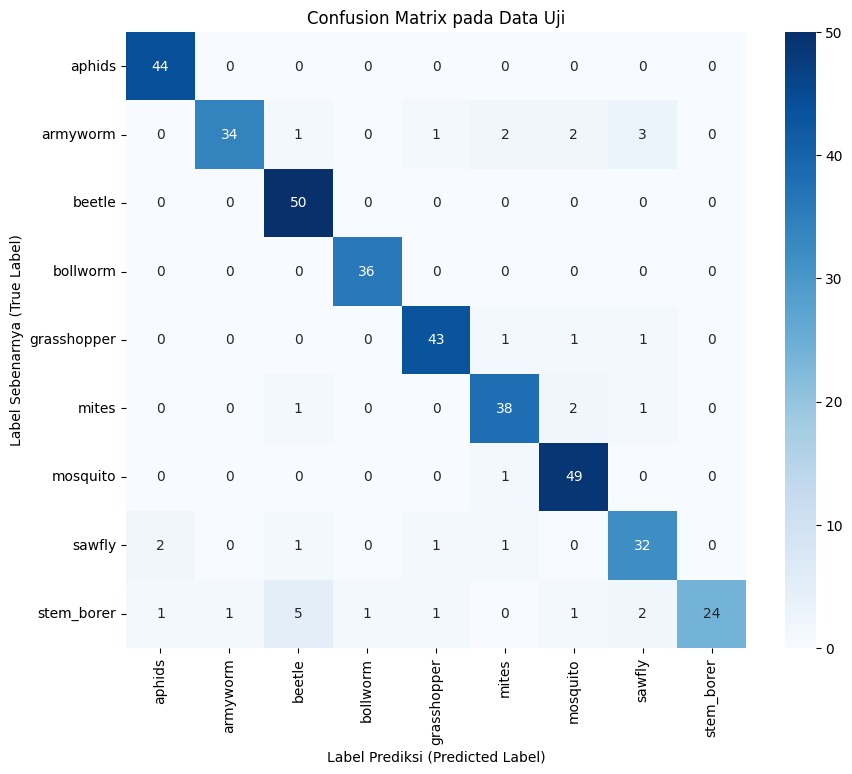

In [ ]:
# 5. Menghasilkan Laporan Klasifikasi (Precision, Recall, F1-Score)
print("\n--- Laporan Klasifikasi (Classification Report) ---")
print(classification_report(true_labels, predicted_labels, target_names=class_names))

# 6. Menghasilkan Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,        # Menampilkan angka di dalam kotak
    fmt="d",           # Format integer
    cmap="Blues",      # Peta warna
    xticklabels=class_names,
    yticklabels=class_names
)
plt.title('Confusion Matrix pada Data Uji')
plt.ylabel('Label Sebenarnya (True Label)')
plt.xlabel('Label Prediksi (Predicted Label)')
plt.show() # Tampilkan gambar di Colab